# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test2_roberta'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "xlm-roberta-base",
}

# Dataset

I will use RoBERTa, but it will be trained with ALL languages!

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)

In [8]:
dataset_train_all = torch.utils.data.ConcatDataset([dataset_train_en, dataset_train_es, dataset_train_fr])

In [9]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [10]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)
dataset_dev_es = SRLDataset_transformer(datasets_paths['ES']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)
dataset_dev_fr = SRLDataset_transformer(datasets_paths['FR']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [11]:
dataset_dev_all = torch.utils.data.ConcatDataset([dataset_dev_en, dataset_dev_es, dataset_dev_fr])

In [12]:
class Object(object):
    pass

dataset_dev_all.dataset = Object()
dataset_dev_all.data_raw = dataset_dev_en.data_raw + dataset_dev_es.data_raw + dataset_dev_fr.data_raw

In [13]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [14]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [15]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [16]:
from torch.utils.data import DataLoader

In [17]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [18]:
dataloader_train_all = DataLoader(
    dataset_train_all,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [19]:
dataloader_dev_all = DataLoader(
    dataset_dev_all,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [20]:
for e in dataloader_dev_all:
    ex_in = e
    break

In [21]:
ex_in.keys()

dict_keys(['input_ids', 'attention_mask', 'roles_formatted', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position', 'predicate_position_formatted', 'pos_tags'])

In [22]:
print(ex_in['input_ids'][0], ex_in['input_ids'].shape)
print(ex_in['output_mask'][0], ex_in['output_mask'].shape)
print(ex_in['roles_formatted'][0], ex_in['roles_formatted'].shape)

tensor([     0,    581, 148855,  67330,      7,    450,     70,  22836,  19085,
          8783,   1286,  35743,     47,  64559,     18,  84382,     70,  43032,
           111,     70,  27165, 232725, 184641,      6,      4,  48031,    136,
           187,   4806,  84616,   1672,  14135,  38109,      6,      5,      2,
             2,  67330,      7,      2,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1]) torch.Size([32, 84])
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
print(ex_in['predicates'][0], ex_in['predicates'].shape)
print(ex_in['predicate_position_formatted'][0], ex_in['predicate_position_formatted'].shape)

tensor([ -1,   0,   0, 297,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         -1,  -1,   0,   0,   0,   0,   0,   0,   0,   0,  -1,   0,   0,   0,
         -1,   0,   0,   0,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]) torch.Size([32, 84])
tensor(3) torch.Size([32])


In [24]:
torch.set_printoptions(edgeitems=80)
print(ex_in['matrix_subwords'].shape,'\n' , ex_in['matrix_subwords'][0][0:6,:10]) # word_ids[0:6] = [None, 0, 1, 2, 2, 3]
torch.set_printoptions(edgeitems=3)

torch.Size([32, 84, 84]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


# Printing model

In [25]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

In [26]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

# Training the XLM-RoBERTa based model

In [27]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'ALL',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer=True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [29]:
history = {}

In [36]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_all, dataloader_dev_all,
    epochs=10, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_roberta_weights_all.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.043419
# Validation loss => 0.062968 | f1-score: arg_iden = 0.874037 arg_class = 0.743396 #
Epoch   1 => avg_loss: 0.042220
# Validation loss => 0.063758 | f1-score: arg_iden = 0.872210 arg_class = 0.745429 #
Epoch   2 => avg_loss: 0.041716
# Validation loss => 0.063314 | f1-score: arg_iden = 0.874769 arg_class = 0.744935 #
Epoch   3 => avg_loss: 0.040623
# Validation loss => 0.063557 | f1-score: arg_iden = 0.876299 arg_class = 0.747519 #
Epoch   4 => avg_loss: 0.039548
# Validation loss => 0.064782 | f1-score: arg_iden = 0.872745 arg_class = 0.744093 #
Epoch   5 => avg_loss: 0.038868
# Validation loss => 0.064797 | f1-score: arg_iden = 0.872177 arg_class = 0.748616 #
Epoch   6 => avg_loss: 0.037498
# Validation loss => 0.064667 | f1-score: arg_iden = 0.872225 arg_class = 0.749542 #
Epoch   7 => avg_loss: 0.036594
# Validation loss => 0.064770 | f1-score: arg_iden = 0.873465 arg_class = 0.750467 #
Epoch   8 => avg_loss: 0.035731
# Validation loss => 0.064466 | 

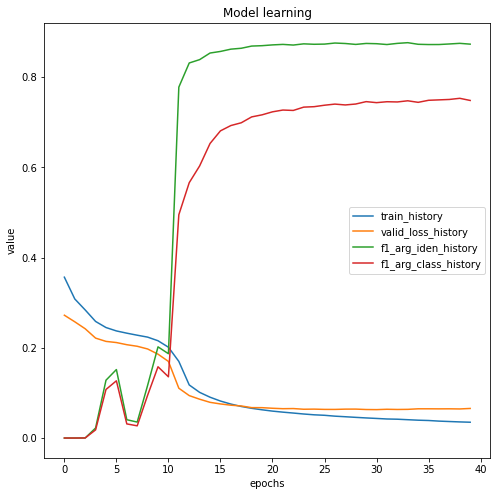

In [37]:
display_history(history)